# Food Preparation Time estimation

## 1. Data Preparation

### 1.1 Import libraries

In [59]:
import numpy as np
import pandas as pd

import datetime
from datetime import time, date, datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

### 1.2 Exploratory Data Analysis (EDA)

### 1.2.1 Examine daata

In [60]:
# Read in the data
df = pd.read_excel("Capstone SampleData 14days.xlsx", sheet_name="Sheet1", header=0)

In [61]:
# Check the data types
df.head()

,JobAcceptedDate,jobAcceptedTime,calledMerchantTime,arrivedAtMerchantTime,mealPickedUpTime,arrivedAtCustLocationTime,foodDeliveredTime,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,Customer.lat,Customer.lng,MerchantName,NationFoodCategory,FoodCategories
0,2020-10-03,20:39:15.840000,20:40:51.840000,20:48:19.840000,20:49:18.840000,21:14:09.840000,21:15:12.840000,13.825853,100.551958,13.825703,100.559309,13.756065,100.562375,3K SEA ZABB,Thai,อาหารทะเล
1,2020-10-01,12:54:34.560000,12:55:38.560000,13:10:26.560000,13:24:56.560000,14:01:00.560000,14:01:39.560000,13.819283,100.561874,13.831056,100.570731,13.774685,100.573913,ร้านอาหารอีสานแม่อลิส,Thai,อาหารอีสาน
2,2020-10-01,12:32:06.720000,12:32:21.720000,12:41:08.720000,12:46:41.720000,13:22:01.720000,13:22:53.720000,13.827041,100.554284,13.827205,100.536048,13.743898,100.571659,ไก่ย่างห้าดาว กรุงเทพ-นนท์44,Thai,Fast Food
3,2020-10-03,13:19:03.360000,13:20:04.360000,13:32:37.360000,13:45:46.360000,14:14:28.360000,14:15:47.360000,13.820453,100.557910,13.840180,100.542326,13.803957,100.513704,กิวกิวเต้ ประชาชื่น,Japanese,ปิ้งย่าง
4,2020-10-13,11:08:26.880000,11:09:03.880000,11:13:43.880000,11:15:32.880000,11:40:26.880000,11:41:23.880000,13.825773,100.567170,13.827034,100.564534,13.775817,100.575734,ร้านอาหาร วินเทส,Thai,อาหารตามสั่ง


In [62]:
df["NationFoodCategory"].value_counts()

Thai             8652
International     939
Japanese          179
Vietnam           103
Isram              45
Korean             45
Myanmar            37
Name: NationFoodCategory, dtype: int64

In [63]:
df["FoodCategories"].value_counts()

อาหารตามสั่ง      6201
อาหารอีสาน         976
ร้านก๋วยเตี๋ยว     917
อาหารทะเล          429
อาหารจานด่วน       335
สปาเก็ตตี้         173
ของหวาน            145
สเต๊ก              111
อาหารเหนือ         110
ขนมจีน              66
สุกี้ยากี้          57
อาหารคลีน           56
ปิ้งย่าง            53
เครื่องดื่ม         53
พิซซ่า              52
Quick Meal          48
อาหารใต้            47
อาหารฮาลาล          45
ร้านอาหาร           45
Fast Food           44
ไก่ทอด              37
Name: FoodCategories, dtype: int64

In [64]:
# Check the data shape
df.shape

(10000, 16)

### 1.2.2 Remove unused columns

In [65]:
# Remove the columns that are not needed
drop_list = ["jobAcceptedTime",
             "mealPickedUpTime",
             "arrivedAtCustLocationTime",
             "foodDeliveredTime",
             "Customer.lat",
             "Customer.lng",
             "MerchantName"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,JobAcceptedDate,calledMerchantTime,arrivedAtMerchantTime,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory,FoodCategories
0,2020-10-03,20:40:51.840000,20:48:19.840000,13.825853,100.551958,13.825703,100.559309,Thai,อาหารทะเล
1,2020-10-01,12:55:38.560000,13:10:26.560000,13.819283,100.561874,13.831056,100.570731,Thai,อาหารอีสาน
2,2020-10-01,12:32:21.720000,12:41:08.720000,13.827041,100.554284,13.827205,100.536048,Thai,Fast Food


### 1.2.3 Change data types (time, date -> datetime)
datetime data type can find interval but both time and date data types cannot.

In [66]:
def to_datetime(df, date_col, time_col):
    return pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str))

In [67]:
if not isinstance(df["calledMerchantTime"].iloc[0], datetime):
    df["calledMerchantTime"]    = to_datetime(df, "JobAcceptedDate", "calledMerchantTime")
if not isinstance(df["arrivedAtMerchantTime"].iloc[0], datetime):
    df["arrivedAtMerchantTime"] = to_datetime(df, "JobAcceptedDate", "arrivedAtMerchantTime")

### 1.2.3 Create target from existed columns

In [68]:
df["FoodPrepTime"] = df["arrivedAtMerchantTime"] - df["calledMerchantTime"] # rider to merchant (1)
# TODO -> arrive time , pickup (pickup - arrivedAtMerchantTime) pickup time (2) , (1) + (2) = foodprep
df["FoodPrepTime (s)"] = df["FoodPrepTime"].apply(lambda x: x.total_seconds())
df["FoodPrepTime (m)"] = df["FoodPrepTime"].apply(lambda x: round(x.total_seconds()/60))

In [69]:
# Remove the columns that are not needed
drop_list = ["JobAcceptedDate",
             "arrivedAtMerchantTime",
             "calledMerchantTime",
             "FoodPrepTime"]
try:
    df.drop(drop_list, axis=1, inplace=True)
except KeyError:
    print("Columns already removed")

display(df.head(3))

,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory,FoodCategories,FoodPrepTime (s),FoodPrepTime (m)
0,13.825853,100.551958,13.825703,100.559309,Thai,อาหารทะเล,448.0,7
1,13.819283,100.561874,13.831056,100.570731,Thai,อาหารอีสาน,888.0,15
2,13.827041,100.554284,13.827205,100.536048,Thai,Fast Food,527.0,9


In [70]:
df["FoodPrepTime (s)"].describe()

count    10000.000000
mean       586.018500
std        255.406457
min        180.000000
25%        399.000000
50%        543.000000
75%        753.000000
max       1499.000000
Name: FoodPrepTime (s), dtype: float64

<AxesSubplot: >

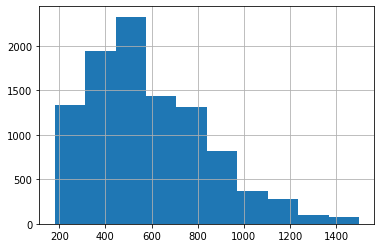

In [71]:
df["FoodPrepTime (s)"].hist()

In [72]:
df["FoodPrepTime (m)"].describe()

count    10000.000000
mean         9.764600
std          4.273548
min          3.000000
25%          7.000000
50%          9.000000
75%         13.000000
max         25.000000
Name: FoodPrepTime (m), dtype: float64

<AxesSubplot: >

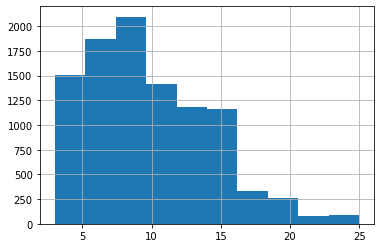

In [73]:
df["FoodPrepTime (m)"].hist()

In [74]:
df.head(2)

,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory,FoodCategories,FoodPrepTime (s),FoodPrepTime (m)
0,13.825853,100.551958,13.825703,100.559309,Thai,อาหารทะเล,448.0,7
1,13.819283,100.561874,13.831056,100.570731,Thai,อาหารอีสาน,888.0,15


## 2. Categorical data

In [75]:
len(df["NationFoodCategory"].unique())

7

In [76]:
len(df["FoodCategories"].unique())

21

In [77]:
# Remove the columns that are not needed
nominal_columns = ["NationFoodCategory",
                    "FoodCategories"]

In [78]:
dummy_df = pd.get_dummies(df[nominal_columns], drop_first=False)
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(nominal_columns, axis=1)

In [79]:
target = df[["FoodPrepTime (s)", "FoodPrepTime (m)"]]
attr = df.drop(["FoodPrepTime (s)", "FoodPrepTime (m)"], axis=1)
df = pd.merge(attr, target, left_index=True, right_index=True)
# df.to_csv("Sample 14days_foodprep (cleaned).csv", index=False)

In [80]:
y_s = df.pop("FoodPrepTime (s)")
y_m = df.pop("FoodPrepTime (m)")
X = df.copy()


## 3. predict as second

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y_s, test_size=0.30, random_state=0)

In [82]:
X_train

,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory_International,NationFoodCategory_Isram,NationFoodCategory_Japanese,NationFoodCategory_Korean,NationFoodCategory_Myanmar,NationFoodCategory_Thai,...,FoodCategories_อาหารคลีน,FoodCategories_อาหารจานด่วน,FoodCategories_อาหารตามสั่ง,FoodCategories_อาหารทะเล,FoodCategories_อาหารอีสาน,FoodCategories_อาหารฮาลาล,FoodCategories_อาหารเหนือ,FoodCategories_อาหารใต้,FoodCategories_เครื่องดื่ม,FoodCategories_ไก่ทอด
7681,13.821047,100.552567,13.838594,100.538436,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9031,13.822144,100.546690,13.840193,100.548363,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3691,13.822933,100.553381,13.827034,100.564534,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
202,13.824288,100.563142,13.839772,100.551639,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5625,13.822967,100.559944,13.823278,100.574473,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9225,13.827778,100.561269,13.827652,100.567833,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4859,13.827772,100.558415,13.839772,100.551639,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3264,13.826384,100.547067,13.827034,100.564534,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9845,13.828216,100.557497,13.824620,100.563396,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
reg = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
reg.fit(X_train, y_train)
score = reg.score(X_train, y_train)
print("Train R-square score: ", score)

Train R-square score:  0.9816698005517983


In [84]:
predictions = reg.predict(X_test)

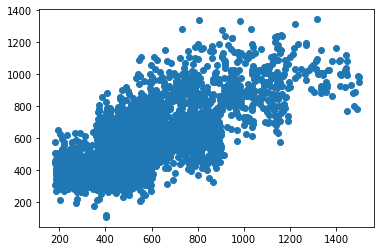

In [85]:
plt.scatter(y_test, predictions)

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_27516/3290896071.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predictions), bins=50);


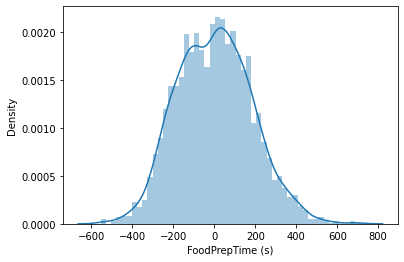

In [86]:
sns.distplot((y_test-predictions), bins=50);

In [87]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 147.77092513691994
MSE: 33324.58074565971
RMSE: 182.55021431282876


In [88]:
result_s = pd.DataFrame({"predict": predictions, "actual": y_test})

In [89]:
result_s.sample(10)

,predict,actual
1029,658.895949,945.0
3667,448.679425,637.0
9896,903.017634,704.0
2984,565.928633,550.0
1326,379.439219,552.0
1373,518.322057,535.0
8095,294.942218,348.0
234,372.003899,456.0
1037,634.020714,884.0
3681,477.308316,590.0


## 4. predict as minute

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y_m, test_size=0.30, random_state=0)

In [91]:
reg = GradientBoostingRegressor(n_estimators=1000, max_depth=7, random_state=0)
reg.fit(X_train, y_train)
score = reg.score(X_train, y_train)
print("Train R-square score: ", score)

Train R-square score:  0.9830662596371232


In [92]:
predictions = reg.predict(X_test)

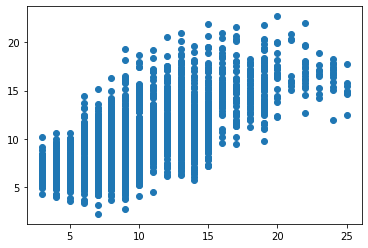

In [93]:
plt.scatter(y_test, predictions)

C:\Users\PoraRee\AppData\Local\Temp/ipykernel_27516/3290896071.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predictions), bins=50);


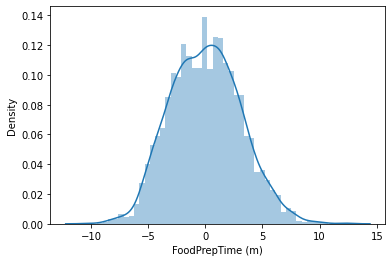

In [94]:
sns.distplot((y_test-predictions), bins=50);

In [95]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.4886058759793324
MSE: 9.475106727182565
RMSE: 3.0781661305365837


In [96]:
result_m = pd.DataFrame({"predict": predictions, "actual": y_test})

In [97]:
result_m.sample(10)

,predict,actual
103,6.302294,7
787,8.049421,4
5920,12.001490,12
4954,10.839621,13
2686,9.171951,6
7432,7.187022,7
938,11.968389,7
9752,15.617855,10
7980,5.733098,9
675,6.950768,4


In [110]:

# TODO: show the feature importance
print(np.argsort(reg.feature_importances_)[::-1])
print(df.columns[np.argsort(reg.feature_importances_)[::-1]])
print(reg.feature_importances_[np.argsort(reg.feature_importances_)[::-1]].astype("str"))

[ 3  1  0  2 24 17 26 25  9  4 23 14  6 11 21 30 20 19 15 29 13 28 31 22
 10  8 18 16  7  5 12 27]
Index(['Merchant.Lng', 'riderInitial.long', 'riderInitial.lat', 'Merchant.Lat',
       'FoodCategories_อาหารตามสั่ง', 'FoodCategories_ร้านก๋วยเตี๋ยว',
       'FoodCategories_อาหารอีสาน', 'FoodCategories_อาหารทะเล',
       'NationFoodCategory_Thai', 'NationFoodCategory_International',
       'FoodCategories_อาหารจานด่วน', 'FoodCategories_ของหวาน',
       'NationFoodCategory_Japanese', 'FoodCategories_Fast Food',
       'FoodCategories_สเต๊ก', 'FoodCategories_เครื่องดื่ม',
       'FoodCategories_สุกี้ยากี้', 'FoodCategories_สปาเก็ตตี้',
       'FoodCategories_ปิ้งย่าง', 'FoodCategories_อาหารใต้',
       'FoodCategories_ขนมจีน', 'FoodCategories_อาหารเหนือ',
       'FoodCategories_ไก่ทอด', 'FoodCategories_อาหารคลีน',
       'NationFoodCategory_Vietnam', 'NationFoodCategory_Myanmar',
       'FoodCategories_ร้านอาหาร', 'FoodCategories_พิซซ่า',
       'NationFoodCategory_Korean', 'NationFoodCate

In [100]:
df.head()

,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory_International,NationFoodCategory_Isram,NationFoodCategory_Japanese,NationFoodCategory_Korean,NationFoodCategory_Myanmar,NationFoodCategory_Thai,...,FoodCategories_อาหารคลีน,FoodCategories_อาหารจานด่วน,FoodCategories_อาหารตามสั่ง,FoodCategories_อาหารทะเล,FoodCategories_อาหารอีสาน,FoodCategories_อาหารฮาลาล,FoodCategories_อาหารเหนือ,FoodCategories_อาหารใต้,FoodCategories_เครื่องดื่ม,FoodCategories_ไก่ทอด
0,13.825853,100.551958,13.825703,100.559309,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,13.819283,100.561874,13.831056,100.570731,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,13.827041,100.554284,13.827205,100.536048,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,13.820453,100.557910,13.840180,100.542326,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.825773,100.567170,13.827034,100.564534,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


## 6. Hyperparameter tuning

In [65]:
import numpy as np
import pandas as pd

from math import sqrt, cos

import networkx as nx

import datetime
from datetime import time, date, datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import metrics


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [5]:
# LOAD CLEANED DATASET
df = pd.read_csv("Sample 14days_foodprep (cleaned).csv")
df.head()

,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory_International,NationFoodCategory_Isram,NationFoodCategory_Japanese,NationFoodCategory_Korean,NationFoodCategory_Myanmar,NationFoodCategory_Thai,...,FoodCategories_อาหารตามสั่ง,FoodCategories_อาหารทะเล,FoodCategories_อาหารอีสาน,FoodCategories_อาหารฮาลาล,FoodCategories_อาหารเหนือ,FoodCategories_อาหารใต้,FoodCategories_เครื่องดื่ม,FoodCategories_ไก่ทอด,FoodPrepTime (s),FoodPrepTime (m)
0,13.825853,100.551958,13.825703,100.559309,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,448.0,7
1,13.819283,100.561874,13.831056,100.570731,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,888.0,15
2,13.827041,100.554284,13.827205,100.536048,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,527.0,9
3,13.820453,100.557910,13.840180,100.542326,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,753.0,13
4,13.825773,100.567170,13.827034,100.564534,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,280.0,5


In [80]:
df.columns

Index(['riderInitial.lat', 'riderInitial.long', 'Merchant.Lat', 'Merchant.Lng',
       'NationFoodCategory_International', 'NationFoodCategory_Isram',
       'NationFoodCategory_Japanese', 'NationFoodCategory_Korean',
       'NationFoodCategory_Myanmar', 'NationFoodCategory_Thai',
       'NationFoodCategory_Vietnam', 'FoodCategories_Fast Food',
       'FoodCategories_Quick Meal', 'FoodCategories_ขนมจีน',
       'FoodCategories_ของหวาน', 'FoodCategories_ปิ้งย่าง',
       'FoodCategories_พิซซ่า', 'FoodCategories_ร้านก๋วยเตี๋ยว',
       'FoodCategories_ร้านอาหาร', 'FoodCategories_สปาเก็ตตี้',
       'FoodCategories_สุกี้ยากี้', 'FoodCategories_สเต๊ก',
       'FoodCategories_อาหารคลีน', 'FoodCategories_อาหารจานด่วน',
       'FoodCategories_อาหารตามสั่ง', 'FoodCategories_อาหารทะเล',
       'FoodCategories_อาหารอีสาน', 'FoodCategories_อาหารฮาลาล',
       'FoodCategories_อาหารเหนือ', 'FoodCategories_อาหารใต้',
       'FoodCategories_เครื่องดื่ม', 'FoodCategories_ไก่ทอด'],
      dtype='object'

In [6]:
y_s = df.pop("FoodPrepTime (s)")
y_m = df.pop("FoodPrepTime (m)")
X = df.copy()
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y_s, test_size=0.20, random_state=0)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X, y_m, test_size=0.20, random_state=0)

In [7]:
import pickle as pkl
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.mplot3d import Axes3D
from pylab import cm
import matplotlib.ticker as mticker

In [184]:
# gbdt = GradientBoostingRegressor(random_state=314159)
# # gbdt.get_params(deep=True)

# param_grid = { 
#  "n_estimators": [50, 75, 100, 125, 150],
#  "max_features": [1.0, "sqrt", "log2"], # "auto" is deprecated, use 1.0 instead
#  "max_depth": [3, 4, 5, 6, 7],
# }

# CV_gbdt_s = GridSearchCV(estimator=gbdt, param_grid=param_grid)
# CV_gbdt_s.fit(Xs_train, ys_train)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=314159),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': [50, 75, 100, 125, 150]})

In [185]:
# pkl.dump(CV_gbdt_s, open("CV_gbdt_s_foodprep.pkl", "wb"))
# pkl.dump(gbdt_s, open("gbdt_s_foodpreap.pkl", "wb"))

In [8]:
CV_gbdt_s = pkl.load(open("CV_gbdt_s_foodprep.pkl", "rb"))
gbdt_s = CV_gbdt_s.best_estimator_

In [9]:
CV_s_result = pd.DataFrame(CV_gbdt_s.cv_results_)

In [10]:
CV_s_result.sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.691156,0.005642,0.004003,0.000010,5,1.0,75,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.587980,0.577698,0.572425,0.575672,0.598097,0.582374,0.009428,1
24,0.473000,0.015524,0.003200,0.000400,5,1.0,50,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.586876,0.576162,0.574736,0.575092,0.595978,0.581769,0.008408,2
26,0.926479,0.009400,0.004296,0.000397,5,1.0,100,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.586935,0.576844,0.571987,0.576233,0.596191,0.581638,0.008777,3
36,0.560727,0.023320,0.004000,0.001095,6,1.0,50,"{'max_depth': 6, 'max_features': 1.0, 'n_estim...",0.578910,0.578397,0.569052,0.580432,0.600985,0.581555,0.010508,4
37,0.849380,0.010153,0.004596,0.000488,6,1.0,75,"{'max_depth': 6, 'max_features': 1.0, 'n_estim...",0.577420,0.577519,0.566956,0.578538,0.598338,0.579754,0.010208,5


In [11]:
CV_gbdt_s.best_params_

{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 75}

In [12]:
gbdt_s = CV_gbdt_s.best_estimator_

In [13]:
gbdt_predictions_s = gbdt_s.predict(Xs_test)

MAE  = metrics.mean_absolute_error(ys_test, gbdt_predictions_s)
MSE  = metrics.mean_squared_error(ys_test, gbdt_predictions_s)
R2   = metrics.r2_score(ys_test, gbdt_predictions_s)
RMSE = np.sqrt(metrics.mean_squared_error(ys_test, gbdt_predictions_s))

Text(0, 0.5, 'Predicted FoodPrepTime (s)')

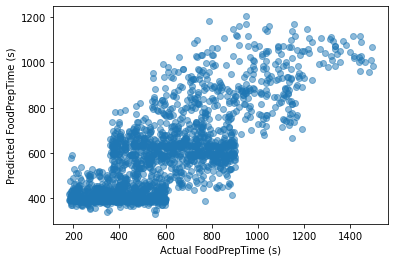

In [62]:
plt.scatter(ys_test, gbdt_predictions_s, alpha=0.5)
plt.xlabel("Actual FoodPrepTime (s)")
plt.ylabel("Predicted FoodPrepTime (s)")

In [72]:
# plt.scatter(gbdt_predictions_s, ys_test/gbdt_predictions_s, alpha=0.1)
# plt.title("gbdt_s")
# plt.xlabel("Predicted")
# plt.ylabel("Actual/Predicted")

In [14]:
import time
n = 100
durations = []
for i in range(n):
    start_time = time.time()
    sample_data = Xs_test.sample(1)
    result = gbdt_s.predict(sample_data)
    end_time = time.time()
    duration = end_time - start_time
    durations.append(duration)
duration_mean = np.mean(durations)
duration_median = np.median(durations)
duration_std = np.std(durations)
print("Mean duration: {:.4f} seconds.".format(duration_mean))
print("Median duration: {:.4f} seconds.".format(duration_median))
print("Standard deviation: {:.4f} seconds.".format(duration_std))

Mean duration: 0.0014 seconds.
Median duration: 0.0010 seconds.
Standard deviation: 0.0006 seconds.


In [15]:
MAE, MSE, R2, RMSE

(138.10122374152178,
 27961.004228908136,
 0.5778495430000926,
 167.21544255513047)

In [37]:
CV_s_result["mean_test_score"].values.min(), CV_s_result["mean_test_score"].values.max()

(0.46369229788060934, 0.5823744450792345)

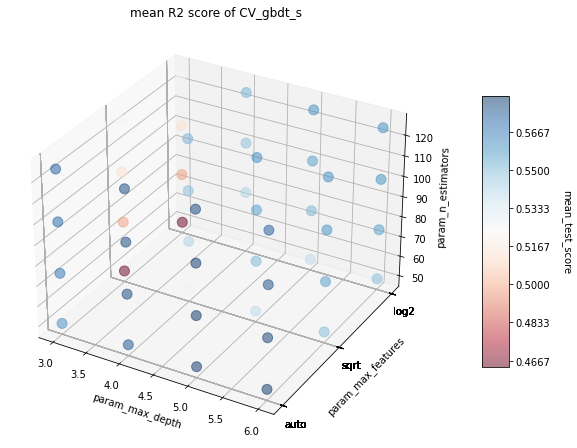

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = CV_s_result["param_max_depth"].values.astype("int")
y = CV_s_result["param_max_features"].map({1.0: 0, "sqrt": 1, "log2": 2}).values.astype("int")
z = CV_s_result["param_n_estimators"].values.astype("int")
colo = CV_s_result["mean_test_score"].values

color_map = cm.ScalarMappable(cmap=cm.RdBu)
# color_map = cm.ScalarMappable(cmap=cm.Greens_r)
color_map.set_array(colo)

img = ax.scatter(xs=x, ys=y, zs=z, c=colo, cmap=cm.RdBu, s=100, alpha=0.5)
# img = ax.scatter(xs=x, ys=y, zs=z, c=colo, cmap=cm.Greens_r, s=100, alpha=0.5)
cbar = fig.colorbar(img, ticks=np.linspace(0.45, 0.60, 10), orientation='vertical', shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('mean_test_score', rotation=270, labelpad=20)

ax.set_title("mean R2 score of CV_gbdt_s")
ax.set_xlabel('param_max_depth')
ax.set_ylabel('param_max_features')
ax.set_zlabel('param_n_estimators')

ax.axes.yaxis.set_major_locator(mticker.FixedLocator(y))
ax.axes.yaxis.set_ticklabels(CV_s_result["param_max_features"].map({1.0: "auto", "sqrt": "sqrt", "log2": "log2"}))
plt.show()

In [57]:
CV_gbdt_s.best_params_

{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 75}

In [17]:
# gbdt = GradientBoostingRegressor(random_state=314159)
# # gbdt.get_params(deep=True)

# param_grid = { 
#  "n_estimators": [50, 75, 100, 125, 150],
#  "max_features": [1.0, "sqrt", "log2"], # "auto" is deprecated, use 1.0 instead
#  "max_depth": [3, 4, 5, 6, 7],
# }

# CV_gbdt_m = GridSearchCV(estimator=gbdt, param_grid=param_grid)
# CV_gbdt_m.fit(Xm_train, ym_train)

In [18]:
# gbdt_m = CV_gbdt_m.best_estimator_

In [19]:
# pkl.dump(CV_gbdt_m, open("CV_gbdt_m_foodprep.pkl", "wb"))
# pkl.dump(gbdt_m, open("gbdt_m_foodpreap.pkl", "wb"))

In [20]:
CV_gbdt_m = pkl.load(open("CV_gbdt_m_foodprep.pkl", "rb"))
gbdt_m = CV_gbdt_m.best_estimator_

In [21]:
import time
n = 100
durations = []
for i in range(n):
    start_time = time.time()
    sample_data = Xm_test.sample(1)
    result = gbdt_m.predict(sample_data)
    end_time = time.time()
    duration = end_time - start_time
    durations.append(duration)
duration_mean = np.mean(durations)
duration_median = np.median(durations)
duration_std = np.std(durations)
print("Mean duration: {:.4f} seconds.".format(duration_mean))
print("Median duration: {:.4f} seconds.".format(duration_median))
print("Standard deviation: {:.4f} seconds.".format(duration_std))

Mean duration: 0.0015 seconds.
Median duration: 0.0010 seconds.
Standard deviation: 0.0006 seconds.


In [22]:
CV_m_result = pd.DataFrame(CV_gbdt_m.cv_results_)

In [23]:
CV_m_result.sort_values(by="rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,0.452376,0.011243,0.003389,0.000483,5,1.0,50,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.581151,0.569935,0.566165,0.569372,0.587384,0.574801,0.008079,1
31,0.694019,0.011692,0.003607,0.000488,5,1.0,75,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.583096,0.571239,0.564589,0.567447,0.586541,0.574583,0.008688,2
32,0.920763,0.008625,0.004198,0.000400,5,1.0,100,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.580884,0.569815,0.563875,0.566777,0.584098,0.573090,0.007968,3
45,0.523244,0.003347,0.003810,0.000410,6,1.0,50,"{'max_depth': 6, 'max_features': 1.0, 'n_estim...",0.574412,0.564710,0.561051,0.571837,0.592327,0.572867,0.010847,4
33,1.140989,0.013708,0.004199,0.000403,5,1.0,125,"{'max_depth': 5, 'max_features': 1.0, 'n_estim...",0.579580,0.568266,0.562667,0.565674,0.582579,0.571753,0.007876,5


In [24]:
CV_gbdt_m.best_params_

{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 50}

In [25]:
gbdt_m = CV_gbdt_m.best_estimator_

In [26]:
gbdt_predictions_m = gbdt_m.predict(Xm_test)

MAE  = metrics.mean_absolute_error(ym_test, gbdt_predictions_m)
MSE  = metrics.mean_squared_error(ym_test, gbdt_predictions_m)
R2   = metrics.r2_score(ym_test, gbdt_predictions_m)
RMSE = np.sqrt(metrics.mean_squared_error(ym_test, gbdt_predictions_m))

In [27]:
MAE, MSE, R2, RMSE

(2.3339400714503697, 8.002344336692984, 0.5672898425151509, 2.8288415184829607)

Text(0, 0.5, 'Predicted FoodPrep Time (m)')

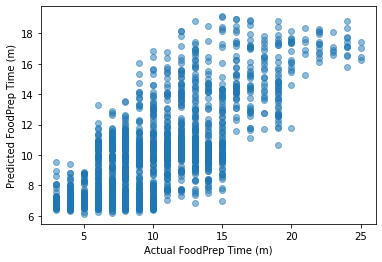

In [63]:
plt.scatter(ym_test, gbdt_predictions_m, alpha=0.5)
plt.xlabel("Actual FoodPrep Time (m)")
plt.ylabel("Predicted FoodPrep Time (m)")

In [71]:
# plt.scatter(gbdt_predictions_m, ym_test/gbdt_predictions_m, alpha=0.1)
# plt.title("gbdt_s")
# plt.xlabel("Predicted")
# plt.ylabel("Actual/Predicted")

In [83]:
df

,riderInitial.lat,riderInitial.long,Merchant.Lat,Merchant.Lng,NationFoodCategory_International,NationFoodCategory_Isram,NationFoodCategory_Japanese,NationFoodCategory_Korean,NationFoodCategory_Myanmar,NationFoodCategory_Thai,...,FoodCategories_อาหารคลีน,FoodCategories_อาหารจานด่วน,FoodCategories_อาหารตามสั่ง,FoodCategories_อาหารทะเล,FoodCategories_อาหารอีสาน,FoodCategories_อาหารฮาลาล,FoodCategories_อาหารเหนือ,FoodCategories_อาหารใต้,FoodCategories_เครื่องดื่ม,FoodCategories_ไก่ทอด
0,13.825853,100.551958,13.825703,100.559309,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,13.819283,100.561874,13.831056,100.570731,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,13.827041,100.554284,13.827205,100.536048,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,13.820453,100.557910,13.840180,100.542326,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13.825773,100.567170,13.827034,100.564534,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,13.820017,100.556861,13.831056,100.570731,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
9996,13.827171,100.562291,13.827034,100.564534,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9997,13.823671,100.550038,13.836996,100.540408,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
9998,13.820751,100.563062,13.839923,100.547567,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [82]:
df["FoodPrepTime"].hist()

KeyError: 'FoodPrepTime'

Text(367.48863636363626, 0.5, 'Predicted')

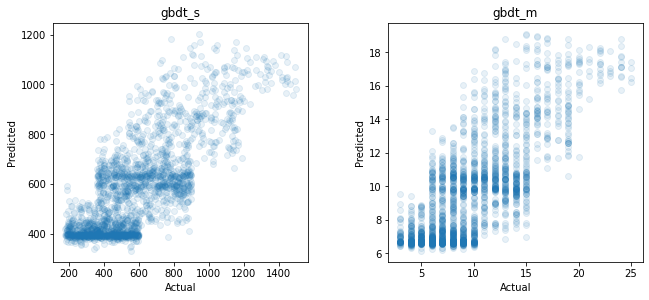

In [73]:

# TODO: plot the act-pred
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test, gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Predicted")

axs[1].scatter(ym_test, gbdt_predictions_m, alpha=0.1)
axs[1].set_title("gbdt_m")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Predicted")


Text(367.48863636363626, 0.5, 'Actual/Predicted')

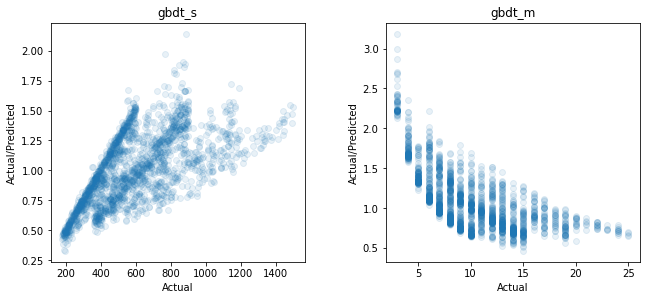

In [84]:

# TODO: plot the act-act/pred
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
axs[0].scatter(ys_test, ys_test/gbdt_predictions_s, alpha=0.1)
axs[0].set_title("gbdt_s")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Actual/Predicted")

axs[1].scatter(ym_test, gbdt_predictions_m/ym_test, alpha=0.1)
axs[1].set_title("gbdt_m")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Actual/Predicted")


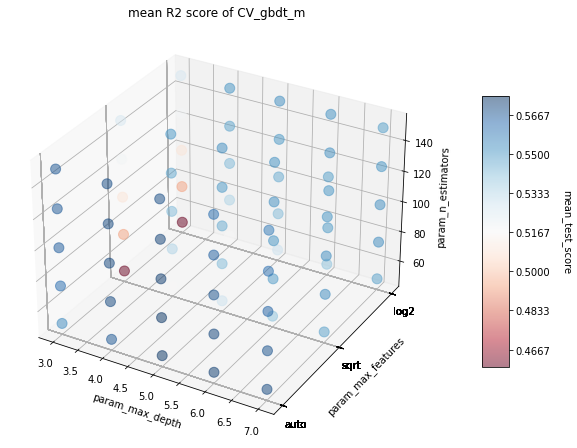

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x = CV_m_result["param_max_depth"].values.astype("int")
y = CV_m_result["param_max_features"].map({1.0: 0, "sqrt": 1, "log2": 2}).values.astype("int")
z = CV_m_result["param_n_estimators"].values.astype("int")
colo = CV_m_result["mean_test_score"].values

color_map = cm.ScalarMappable(cmap=cm.RdBu)
# color_map = cm.ScalarMappable(cmap=cm.Greens_r)
color_map.set_array(colo)

img = ax.scatter(xs=x, ys=y, zs=z, c=colo, cmap=cm.RdBu, s=100, alpha=0.5)
# img = ax.scatter(xs=x, ys=y, zs=z, c=colo, cmap=cm.Greens_r, s=100, alpha=0.5)
cbar = fig.colorbar(img, ticks=np.linspace(0.45, 0.60, 10), orientation='vertical', shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('mean_test_score', rotation=270, labelpad=20)

ax.set_title("mean R2 score of CV_gbdt_m")
ax.set_xlabel('param_max_depth')
ax.set_ylabel('param_max_features')
ax.set_zlabel('param_n_estimators')

ax.axes.yaxis.set_major_locator(mticker.FixedLocator(y))
ax.axes.yaxis.set_ticklabels(CV_m_result["param_max_features"].map({1.0: "auto", "sqrt": "sqrt", "log2": "log2"}))
plt.show()

In [56]:
CV_gbdt_m.best_params_

{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 50}

In [79]:

# TODO: show the feature importance
print(np.argsort(gbdt_s.feature_importances_)[::-1])
print(df.columns[np.argsort(gbdt_s.feature_importances_)[::-1]])
print(gbdt_s.feature_importances_[np.argsort(gbdt_s.feature_importances_)[::-1]].astype("str"))


print(np.argsort(gbdt_m.feature_importances_)[::-1])
print(df.columns[np.argsort(gbdt_m.feature_importances_)[::-1]])
print(gbdt_s.feature_importances_[np.argsort(gbdt_m.feature_importances_)[::-1]].astype("str"))

[ 3  1  2  0 24 25 30 17 20  9 26 23 21 19 15  4 11 12 10  8 29  6 28 18
 16  7  5 22 27 13 14 31]
Index(['Merchant.Lng', 'riderInitial.long', 'Merchant.Lat', 'riderInitial.lat',
       'FoodCategories_อาหารตามสั่ง', 'FoodCategories_อาหารทะเล',
       'FoodCategories_เครื่องดื่ม', 'FoodCategories_ร้านก๋วยเตี๋ยว',
       'FoodCategories_สุกี้ยากี้', 'NationFoodCategory_Thai',
       'FoodCategories_อาหารอีสาน', 'FoodCategories_อาหารจานด่วน',
       'FoodCategories_สเต๊ก', 'FoodCategories_สปาเก็ตตี้',
       'FoodCategories_ปิ้งย่าง', 'NationFoodCategory_International',
       'FoodCategories_Fast Food', 'FoodCategories_Quick Meal',
       'NationFoodCategory_Vietnam', 'NationFoodCategory_Myanmar',
       'FoodCategories_อาหารใต้', 'NationFoodCategory_Japanese',
       'FoodCategories_อาหารเหนือ', 'FoodCategories_ร้านอาหาร',
       'FoodCategories_พิซซ่า', 'NationFoodCategory_Korean',
       'NationFoodCategory_Isram', 'FoodCategories_อาหารคลีน',
       'FoodCategories_อาหารฮาลาล', 'Food

In [ ]:

#TODO pickup-arrive, pickup-call